In [12]:
import os
import random
import shutil
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os
from scipy.stats import linregress

# Moving random file to test data dir

In [89]:
import os
import random
import shutil

def select_and_copy_random_files(directories, destination_dir, total_files=300):
    # Get the list of all files from each directory
    all_files = []
    for directory in directories:
        files = os.listdir(directory)
        all_files.extend(files)

    #Check theres enough files
    if len(all_files) < total_files:
        raise ValueError(f"Not enough files in total. Only {len(all_files)} files available.")

    #Select random files
    selected_files = random.sample(all_files, total_files)

    #Shuffle the selected files
    random.shuffle(selected_files)

    #Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    #Copy the selected files to directory
    for file in selected_files:
        source_file = None
        folder_name = None
        
       
        for directory in directories:
            if file in os.listdir(directory):
                source_file = os.path.join(directory, file)
                folder_name = os.path.basename(directory)  # Folder name as part of the new filename
                break
        
        # Rename file to know where it came from 
        new_file_name = f"{folder_name}_{file}"
        destination_file = os.path.join(destination_dir, new_file_name)

        # Copy the file 
        shutil.copy(source_file, destination_file)

    print(f"Successfully copied {total_files} files to {destination_dir} with the renaming scheme.")

# List of directories to select files from
directories = [
    #"FINALDATA/Split_Data/Evolved+disk/EDNS",
    "FINALDATA/Split_Data/Evolved+disk/EDS",
    #"FINALDATA/Split_Data/Evolved/ENS",
    "FINALDATA/Split_Data/Evolved/ES",  
    #"FINALDATA/Split_Data/WT/WTNS",  
    "FINALDATA/Split_Data/WT/WTS",  
]

destination_dir = "FINALDATA/Grad_split/test"

select_and_copy_random_files(directories, destination_dir, total_files=100)


Successfully copied 100 files to FINALDATA/Grad_split/test with the renaming scheme.


# Definitions

In [1]:
def mean_squared_displacement_optimised(file_path):
    """
    This function calculates an array of mean squared displacment values for a time lag value tau
    and puts them in to a dictionary of the time lag tau and msd calculated.
    Inputs - 
    file_path: take in the file to calculate this on.
    
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])
    time = np.array(data['time'])
    
    msd_by_tau = {}

    for tau in range(1, len(time)):
        
        dx = x_smooth[tau:] - x_smooth[:-tau]
        dy = y_smooth[tau:] - y_smooth[:-tau]
        dz = z_smooth[tau:] - z_smooth[:-tau]
        squared_displacements = dx**2 + dy**2 + dz**2
        msd_by_tau[round(time[tau] - time[0], 3)] = np.mean(squared_displacements)

    return msd_by_tau


def find_gradient_intercept(file_path):
    """
    Uses the MSD and Tau values to calculated a gradient of log(MSD) vs log(Tau) graph, The limit of this
    can be changed, but was chosen to be 1 20th of the range of tau as this gives very good R values.
    Inputs - 
    file_path: take in the file to calculate this on.
    
    """
    msd_by_tau = mean_squared_displacement_optimised(file_path)
    #Splitting tau and msd 
    tau_arr = np.array(list(msd_by_tau.keys()))
    msd_arr = np.array(list(msd_by_tau.values()))
    
    #Setting tau limit 
    tau_max = tau_arr.max()
    tau_limit = tau_max / 20
    mask = tau_arr <= tau_limit
    
    #Limited arrays
    limited_tau = tau_arr[mask]
    limited_msd = msd_arr[mask]
    
    #Log the data 
    log_tau = np.log(limited_tau)
    log_msd = np.log(limited_msd)
    
    #Find gradient and intercept 
    try:
        slope, intercept, _, _, _ = linregress(log_tau, log_msd)
        return slope, intercept
    except ValueError:
        return np.nan, np.nan

In [5]:
def calc_curvature_arr(file_path):
    """
    Uses the Frenet Serret equations in order to calculate the instantaneous curvature of the track
    Out puts and array of curvatures with the first two nd last two points missing due to the use of the 
    difference method, twice. Logic of this method is outlined in the project notebook.
    Inputs - 
    file_path: take in the file to calculate this on. 
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    if len(data) <= 2:
        return np.array([])
    v_arr = np.zeros(len(data)) #init velocity array 
    t_arr = np.zeros(len(data))  #init time array    
    T_arr = np.zeros((len(data)-2, 4))  # 2D array with time + 3 components t, x,y,z

    for i in range(1, len(data)-1):

    
        x_smooth = np.array(data['x_smooth'])  #Extracting data
        y_smooth = np.array(data['y_smooth'])
        z_smooth = np.array(data['z_smooth'])
        time = np.array(data['time'])
    
        t_next = time[i+1]       #Define points for central difference
        x_next = x_smooth[i+1]
        y_next = y_smooth[i+1]
        z_next = z_smooth[i+1]
    
        t_prev = time[i-1]
        x_prev = x_smooth[i-1]
        y_prev = y_smooth[i-1]
        z_prev = z_smooth[i-1]
        dir_vector = np.array([x_next - x_prev, y_next - y_prev, z_next - z_prev])
        T_vector = dir_vector / np.linalg.norm(dir_vector)
        T_arr[i-1] = np.array([time[i], *T_vector])  
    
        r_diff = np.sqrt((x_next-x_prev)**2+(y_next-y_prev)**2+(z_next-z_prev)**2)
        dt = t_next - t_prev
        v = r_diff/ (dt)

        v_arr[i] = v
    time_for_T = time[1:-1] # Time associated with the T vectors, lost first and last point 
        
    v_arr = v_arr[2:-2]    #velocity for final calculation. Los first and last two points
        

    dT_arr = np.zeros((len(T_arr)-2, 4))  #init dT array, loses frist and last point from T_arr
    
    for i in range(1, len(T_arr)-1):
        dT = (T_arr[i+1, 1:] - T_arr[i-1, 1:]) / (T_arr[i+1, 0] - T_arr[i-1, 0])   #central diff for dT/dt 
        dT_arr[i-1] = np.array([T_arr[i, 0], *dT])#Put associated t x, y ,z in array
        
    curvature_arr = np.zeros(len(dT_arr))    #init curve array 
    
    for i in range(len(v_arr)):
        
        dT_segment = dT_arr[i, 1:]    #extract only x y z 
        dT_magnitude = np.linalg.norm(dT_segment)  #mag of x y z vector 
        v_mag = v_arr[i] #veloctity associated with this point 
        
        curvature = dT_magnitude / v_mag  #calculate curvature
        curvature_arr[i] = curvature   #put in array 
    times_for_curvature = time[2:-2]   #Time associated with the curvature array.
    
    return curvature_arr , times_for_curvature  #Return curvatre and associated time array for plotting.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def calc_acc(file_path):
     """
    Uses the central difference method to calculate the instantaneous acceleration of the track
    Outputs and array of accellerations with the first two nd last two points missing due to the use of the 
    central difference method, twice. The same logic is used for this method as the velocity. 
    Inputs - 
    file_path: take in the file to calculate this on. 
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    if len(data) <= 2:
        return np.array([])
    v_arr = np.zeros(len(data))
    t_arr = np.zeros(len(data)-1)
    a_arr = np.zeros(len(data)-2)
    for i in range(1,len(data)-1):
        data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
        x_smooth = np.array(data['x_smooth'])
        y_smooth = np.array(data['y_smooth'])
        z_smooth = np.array(data['z_smooth'])
        time = np.array(data['time'])
    
        t_next = time[i+1]
        x_next = x_smooth[i+1]
        y_next = y_smooth[i+1]
        z_next = z_smooth[i+1]
    
        t_prev = time[i-1]
        x_prev = x_smooth[i-1]
        y_prev = y_smooth[i-1]
        z_prev = z_smooth[i-1]
        r_diff = np.sqrt((x_next-x_prev)**2+(y_next-y_prev)**2+(z_next-z_prev)**2)
        dt = t_next - t_prev
  
  
    #velocity at the current point using central difference
        
    
        v_arr[i] = r_diff / dt
    
    t_arr = time[1:-1]
    v_arr = v_arr[1:-1]

        
    for i in range(1, len(v_arr) - 1):
        dv = (v_arr[i + 1] - v_arr[i - 1])
        dt = time[i + 1] - time[i - 1]
        a_arr[i] = dv / dt
    t_for_acc = time [2:-2] 
    a_arr = a_arr[1:-1]   
    return a_arr , t_for_acc
    

In [7]:
def calc_velo_arr(file_path):
    """
    Uses the central difference method to calculate the instantaneous velocity of the track
    Outputs and array of velocities with the first and last points missing due to the use of the 
    central difference method. These are removed from the subsequenct array. 
    Inputs - 
    file_path: take in the file to calculate this on. 
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])
    time = np.array(data['time'])
    if len(data) <= 2:
        return np.array([])
    v_arr = np.zeros(len(data)-2)
    
 
    

    for i in range(1,len(data)-1):
        t_next = time[i+1]
        x_next = x_smooth[i+1]
        y_next = y_smooth[i+1]
        z_next = z_smooth[i+1]
    
        t_prev = time[i-1]
        x_prev = x_smooth[i-1]
        y_prev = y_smooth[i-1]
        z_prev = z_smooth[i-1]
    
    # Calculate radial distance for next and previous points
 
    
    
        r_diff = np.sqrt((x_next-x_prev)**2+(y_next-y_prev)**2+(z_next-z_prev)**2)
        dt = t_next - t_prev
  
  
    #velocity at the current point using central difference
        v = r_diff/ (dt)

        v_arr[i-1] = v
        
    return v_arr
        

In [8]:

def calculate_path_length(file_path):
    """
    Calculates the total disatance travelled by the bacterial track by summing the consective distances
    between points.
    Inputs - 
    file_path: take in the file to calculate this on.
    """
    # Read the data from the .txt file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None,
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Extract x_smooth, y_smooth, and z_smooth for path length calculation
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])

    # Calculate the path length as the sum of the distances between consecutive points
    path_length = np.sum(np.sqrt(np.diff(x_smooth)**2 + np.diff(y_smooth)**2 + np.diff(z_smooth)**2))
    
    return path_length

def calculate_straight_distance(file_path):
    """
    Calculates the displacment of the bacterial track by subracting the end and start points.
    Inputs - 
    file_path: take in the file to calculate this on.
    """
    # Read the data from the .txt file
    data = pd.read_csv(file_path, delim_whitespace=True, header=None,
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    # Extract starting and ending coordinates
    start_point = data.iloc[0][['x_smooth', 'y_smooth', 'z_smooth']].to_numpy()
    end_point = data.iloc[-1][['x_smooth', 'y_smooth', 'z_smooth']].to_numpy()
    
    # Calculate the straight-line distance
    straight_distance = np.linalg.norm(end_point - start_point)
    
    return straight_distance

def calculate_tortuosity(file_path):
    """
    Calculates the tortuosity of the bacterial track by taking the ration of the path length to the displacment
    Inputs - 
    file_path: take in the file to calculate this on.
    """
    path_length = calculate_path_length(file_path)
    straight_distance = calculate_straight_distance(file_path)
    
    # Avoid division by zero
    if straight_distance == 0:
        return np.inf  # Tortuosity is infinite if the straight distance is zero
    
    # Tortuosity calculation
    tortuosity = path_length / straight_distance
    return tortuosity

In [9]:
def reorientation_events_per_second(file_path, change_in_dot_thresh, consecutive_low_values, k):
    """
    Calculates rate of re-orientations through use of the taking the dot product bbetween the ith and ith+k vectors,
    if there is more than the consecutive_low_values threshold below the change_in_dot_thresh, then this is an event.
    Inputs - 
    file_path: take in the file to calculate this on
    change_in_dot_thresh: how low should the dot product go to constitute a change in direction 
    consecutive_low_values: How many consecutive dot products below the threshold constitutes directional change
    k: dotting between the ith and ith+k vector. 
    """
    data = pd.read_csv(file_path, delim_whitespace=True, header=None,
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])
    time = data['time']
    
    positions = np.stack((x_smooth, y_smooth, z_smooth), axis=1)

    # Calculate differences in positional vectors between consecutive points
    dir_vectors = np.diff(positions, axis=0)
    # Calculate magnitudes of vectors
    mags = np.linalg.norm(dir_vectors, axis=1)

    # Avoid division by zero
    non_zero_mags = mags > 0  
    unit_dir = np.zeros_like(dir_vectors)  
    unit_dir[non_zero_mags] = dir_vectors[non_zero_mags] / mags[non_zero_mags, np.newaxis]

    dot_products = [np.dot(unit_dir[i], unit_dir[i + k]) for i in range(len(unit_dir) - k) if i + k < len(unit_dir)]

    low_sequences = []
    current_sequence = []

    for dp in dot_products:
        if dp < change_in_dir_threshold:
            current_sequence.append(dp)
        else:
            if len(current_sequence) >= consecutive_low_values:
                low_sequences.append(current_sequence)
            current_sequence = []  # Reset for the next sequence

    if len(current_sequence) >= consecutive_low_values:
        low_sequences.append(current_sequence)

    # Calculate events per second
    events_per_sec = len(low_sequences) / (np.max(time) - np.min(time))
    return events_per_sec

# Creating DF

In [13]:
import os
import pandas as pd
import numpy as np

def extract_features_to_array(file_path, min_length=10):
    # Extract features from file
    msd_by_tau = mean_squared_displacement_optimised(file_path)
    velocity = calc_velo_arr(file_path)
    acceleration = calc_acc(file_path)
    reorientations_per_sec = reorientation_events_per_second(file_path)
    curvature = calc_curvature_arr(file_path)
    tortuosity = calculate_tortuosity(file_path)
    path_length = calculate_path_length(file_path)
    slope, intercept = find_gradient_intercept(file_path)
    
    # Check the length of the data (if track is too short, skip it)
    if len(msd_by_tau) < min_length or len(velocity) < min_length:
        return None  # Skip tracks that are too short
    
    # Ensure features arrays have values, or use np.nan if empty
    msd_arr = np.array(list(msd_by_tau.values())) if len(msd_by_tau) > 0 else np.nan
    log_velocity = np.log(velocity[velocity > 0]) if len(velocity) > 0 else np.nan
    
    # Return exactly 21 features (track_type, filename, and 19 features)
    features = [
        slope if slope else np.nan,
        intercept if intercept else np.nan,
        np.mean(log_velocity) if len(log_velocity) > 0 else np.nan,
        np.std(log_velocity) if len(log_velocity) > 0 else np.nan,
        np.max(log_velocity) if len(log_velocity) > 0 else np.nan,
        np.min(log_velocity) if len(log_velocity) > 0 else np.nan,  # Log velocity features
        np.mean(acceleration) if len(acceleration) > 0 else np.nan, 
        np.std(acceleration) if len(acceleration) > 0 else np.nan,
        np.max(acceleration) if len(acceleration) > 0 else np.nan, 
        np.min(acceleration) if len(acceleration) > 0 else np.nan,  # Acceleration features
        reorientations_per_sec if reorientations_per_sec else np.nan,  # Reorientation events
        np.mean(curvature) if len(curvature) > 0 else np.nan,
        np.std(curvature) if len(curvature) > 0 else np.nan,
        np.max(curvature) if len(curvature) > 0 else np.nan,  # Curvature features
        tortuosity if tortuosity else np.nan, 
        path_length if path_length else np.nan  # Tortuosity and path length
    ]
    
    return features

def feature_df(directory_path, min_length=10, save_path="FINALDATA/Grad_split/txt_data", output_file="test.csv"):
    """
    Creates a CSV file with extracted features and returns a DataFrame.

   Inputs
    directory_path: Path to the directory with input files.
    min_length: Minimum track length to consider.
    save_path: Directory to save the output CSV file.
    output_file: Name of the output CSV file.

    Returns:
    - df (pd.DataFrame): DataFrame of extracted features.
    """
    all_features = []  # List to store valid feature data
    
    # Ensure the output directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Iterate through files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        
        if os.path.isfile(file_path):  # Ensure it's a file
            features = extract_features_to_array(file_path, min_length)
            
            if features is not None:  # Only add valid tracks
                track_type = filename.split('_')[0]  # Assuming type is in the filename
                all_features.append([track_type, filename] + features)
    
    # Remove any None values (files that didn't meet length threshold)
    all_features = [feature for feature in all_features if feature is not None]
    
    # Convert list of valid features to a DataFrame
    df = pd.DataFrame(all_features, columns=[
        'track_type', 'filename',
        'gradient', 'intercept', 'mean_log_velocity', 'stddev_log_velocity',
        'max_log_velocity', 'min_log_velocity', 'mean_acceleration', 'stddev_acceleration',
        'max_acceleration', 'min_acceleration', 'reorientations_per_sec', 'mean_curvature',
        'stddev_curvature', 'max_curvature', 'tortuosity', 'path_length'
    ])
    
    # Save DataFrame as a CSV file in the specified directory
    output_path = os.path.join(save_path, output_file)
    df.to_csv(output_path, index=False)
    
    print(f"Features saved to {output_path}")
    return df


In [14]:
df = feature_df('FINALDATA/Grad_split/test/')

FileNotFoundError: [Errno 2] No such file or directory: 'FINALDATA/Grad_split/test/'

# Rename all directories

In [105]:
import os

def rename_files_in_directory_with_prefix(directory, prefix="EDS_"):
    """
    Renames files in a directory so that all file names start with a specified prefix.

    Parameters:
    - directory (str): Path to the directory whose files will be renamed.
    - prefix (str): The prefix to add to each file name (default: 'WTS_').
    """
    # Loop through all files in the directory
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        
        # Check if it's a file (not a subdirectory)
        if os.path.isfile(file_path):
            # Skip renaming if the file name already starts with the prefix
            if not file_name.startswith(prefix):
                # Create the new file name
                new_file_name = f"{prefix}{file_name}"
                new_file_path = os.path.join(directory, new_file_name)
                
                # Rename the file
                os.rename(file_path, new_file_path)
    
    print(f"Renamed all files in {directory} to start with '{prefix}'.")

# Example usage
directory = "FINALDATA/Grad_split/EDS/"
rename_files_in_directory_with_prefix(directory)


Renamed all files in FINALDATA/Grad_split/EDS/ to start with 'EDS_'.


Removed leading underscores from all files in FINALDATA/Grad_split/WTS/.


# Just make CSV

In [10]:
import os
import csv
import numpy as np

def extract_features_to_array(file_path, min_length=10):
    # Extract features from file
    msd_by_tau = mean_squared_displacement_optimised(file_path)
    velocity = calc_velo_arr(file_path)
    acceleration = calc_acc(file_path)
    reorientations_per_sec = reorientation_events_per_second(file_path)
    curvature = calc_curvature_arr(file_path)
    tortuosity = calculate_tortuosity(file_path)
    path_length = calculate_path_length(file_path)
    slope, intercept = find_gradient_intercept(file_path)
    
    # Check the length of the data (if track is too short, skip it)
    if len(msd_by_tau) < min_length or len(velocity) < min_length:
        return None  # Skip tracks that are too short
    
    # Ensure features arrays have values, or use np.nan if empty
    msd_arr = np.array(list(msd_by_tau.values())) if len(msd_by_tau) > 0 else np.nan
    log_velocity = np.log(velocity[velocity > 0]) if len(velocity) > 0 else np.nan
    
    # Return exactly 19 features
    features = [
        slope if slope else np.nan,
        intercept if intercept else np.nan,
        np.mean(log_velocity) if len(log_velocity) > 0 else np.nan,
        np.std(log_velocity) if len(log_velocity) > 0 else np.nan,
        np.max(log_velocity) if len(log_velocity) > 0 else np.nan,
        np.min(log_velocity) if len(log_velocity) > 0 else np.nan,  # Log velocity features
        np.mean(acceleration) if len(acceleration) > 0 else np.nan, 
        np.std(acceleration) if len(acceleration) > 0 else np.nan,
        np.max(acceleration) if len(acceleration) > 0 else np.nan, 
        np.min(acceleration) if len(acceleration) > 0 else np.nan,  # Acceleration features
        reorientations_per_sec if reorientations_per_sec else np.nan,  # Reorientation events
        np.mean(curvature) if len(curvature) > 0 else np.nan,
        np.std(curvature) if len(curvature) > 0 else np.nan,
        np.max(curvature) if len(curvature) > 0 else np.nan,  # Curvature features
        tortuosity if tortuosity else np.nan, 
        path_length if path_length else np.nan  # Tortuosity and path length
    ]
    
    return features

def write_features_to_csv(directory_path, min_length=10, save_path="FINALDATA/Grad_split/txt_data", output_file="EDNS.csv"):
    """
    Extracts features from files in a directory and directly writes them to a CSV file.

   Inputs
    directory_path: Path to the directory with input files.
    min_length: Minimum track length to consider.
    save_path: Directory to save the output CSV file.
    output_file: Name of the output CSV file.
    """
    # Ensure the output directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    output_path = os.path.join(save_path, output_file)
    
    # Open CSV file for writing
    with open(output_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        
        # Write the header row
        csv_writer.writerow([
            'track_type', 'filename',
            'gradient', 'intercept', 'mean_log_velocity', 'stddev_log_velocity',
            'max_log_velocity', 'min_log_velocity', 'mean_acceleration', 'stddev_acceleration',
            'max_acceleration', 'min_acceleration', 'reorientations_per_sec', 'mean_curvature',
            'stddev_curvature', 'max_curvature', 'tortuosity', 'path_length'
        ])
        
        # Iterate through files in the directory
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):  # Ensure it's a file
                features = extract_features_to_array(file_path, min_length)
                
                if features is not None:  # Only add valid tracks
                    track_type = filename.split('_')[0]  # Assuming type is in the filename
                    csv_writer.writerow([track_type, filename] + features)
    
    print(f"Features saved to {output_path}")



In [11]:
write_features_to_csv('FINALDATA/Grad_split/EDNS/')

NameError: name 'linregress' is not defined

# MACHINE LEARNING WORK IN PROGRESS NOT TOO RELEVENT YET NEED VIKIING

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = df.select_dtypes(include=['float64', 'int64'])
X = X.drop([
     'min_log_velocity',
     'max_log_velocity',
     'max_acceleration', 
     'min_acceleration', 
     'max_curvature'],
    axis=1)
X = X.drop('gradient', axis = 1 )

# Replace NaN values with the mean of each column
X_filled = X.apply(lambda col: col.fillna(col.mean()), axis=0)

# Confirm there are no NaN values left
print("Remaining NaNs:", X_filled.isna().sum().sum())  # Should output 0


KeyError: "['min_log_velocity' 'max_log_velocity' 'max_acceleration'\n 'min_acceleration' 'max_curvature'] not found in axis"

In [70]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)
y = df['track_type']
X_train, X_test, y_train, y_test = train_test_split(X_filled, y, test_size=0.5, random_state=42)


In [73]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for preprocessing
    ('mlp', MLPClassifier(max_iter=10000))  # MLPClassifier instance
])

# List to store accuracy scores from each run
accuracy_scores = []

# Perform 5 runs
for i in range(10):
    # Train the model on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy and append to the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"Run {i+1}: Accuracy = {accuracy * 100:.2f}%")

# Calculate and print the average accuracy
average_accuracy = np.mean(accuracy_scores)
print(f"\nAverage Accuracy over 5 runs: {average_accuracy * 100:.2f}%")


Run 1: Accuracy = 62.29%
Run 2: Accuracy = 62.48%
Run 3: Accuracy = 61.81%
Run 4: Accuracy = 64.00%
Run 5: Accuracy = 62.48%
Run 6: Accuracy = 61.90%
Run 7: Accuracy = 63.14%
Run 8: Accuracy = 63.81%
Run 9: Accuracy = 62.00%
Run 10: Accuracy = 62.67%

Average Accuracy over 5 runs: 62.66%


In [62]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Define a pipeline without grid search
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA(n_components=10)),  # Use 15 principal components to reduce dimensionality
    ('classifier', VotingClassifier(  # Ensemble of three classifiers
        estimators=[
            ('mlp', MLPClassifier(max_iter=1000, hidden_layer_sizes=(50, 30), alpha=0.001, learning_rate_init=0.01)),
            ('rf', RandomForestClassifier(n_estimators=100)),
            ('gb', GradientBoostingClassifier(learning_rate=0.1, n_estimators=100))
        ],
        voting='soft'  # Soft voting to average probabilities from all classifiers
    ))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Print the accuracy score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 86.39%


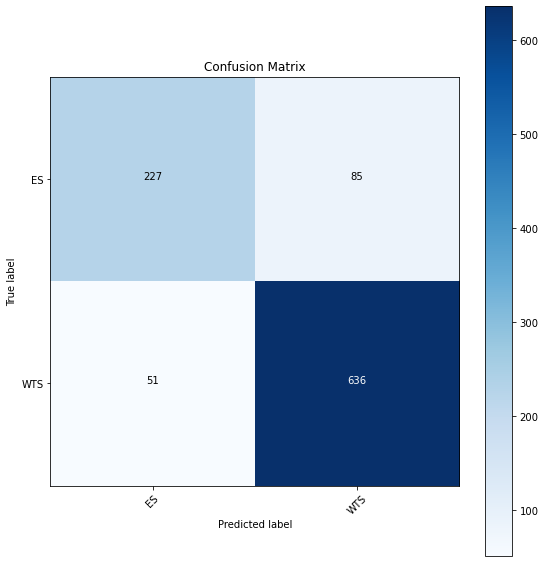

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

# Assuming y_test and y_pred are available from your model's predictions
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

# Display class labels on axes
tick_marks = range(len(pipeline.named_steps['classifier'].classes_))
plt.xticks(tick_marks, pipeline.named_steps['classifier'].classes_, rotation=45)
plt.yticks(tick_marks, pipeline.named_steps['classifier'].classes_)

# Add text annotations within the matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [232]:
from sklearn.model_selection import GridSearchCV

# Simplified parameter grid
param_grid = {
    'pca__n_components': [10, 11],  # Fewer PCA components to test
    'classifier__mlp__hidden_layer_sizes': [(50, 30), (60, 40)],  # Fewer hidden layer sizes for MLP
    'classifier__rf__n_estimators': [100, 150],  # Only two options for RandomForest trees
    'classifier__gb__n_estimators': [100, 150]  # Fewer boosting stages for GradientBoosting
}

# Initialize GridSearchCV with fewer options and a 3-fold CV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation to reduce time
    n_jobs=-1,  # Use all available cores
    scoring='accuracy'  # Use accuracy as the metric
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score: {:.2f}%".format(grid_search.best_score_ * 100))

# Predict on the test set with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the accuracy score of the best model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Best Model: {accuracy * 100:.2f}%")


Best Parameters: {'classifier__gb__n_estimators': 100, 'classifier__mlp__hidden_layer_sizes': (60, 40), 'classifier__rf__n_estimators': 150, 'pca__n_components': 11}
Best Cross-Validation Score: 61.80%
Test Accuracy with Best Model: 58.00%


In [307]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for preprocessing
    ('mlp', MLPClassifier(max_iter=20000, early_stopping=True))  # MLP Classifier
])

# Define the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (50, 30), (100, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring='accuracy', 
    n_jobs=-1,  # Use all processors for parallelism
    cv=5,  # 5-fold cross-validation
    verbose=2
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate test accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50, 30), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Best cross-validation accuracy: 0.90
Test Accuracy: 88.80%


In [308]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging
import numpy as np

# Set up logging to monitor grid search progress
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for preprocessing
    ('mlp', MLPClassifier(max_iter=20000, early_stopping=True))  # MLP Classifier
])

# Define an extended parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (50, 30), (100, 50), (100, 100), (150, 75)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],  # Added 'logistic' for additional exploration
    'mlp__solver': ['adam', 'sgd', 'lbfgs'],  # 'lbfgs' solver for small datasets
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rates
    'mlp__batch_size': [32, 64, 128],  # Batch sizes for training
    'mlp__learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
}

# GridSearchCV setup
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring='accuracy', 
    n_jobs=-1,  # Use all processors for parallelism
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Detailed output during training
    return_train_score=True  # Retain training scores
)

# Fit GridSearchCV on the training data
logging.info("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

# Output best parameters and cross-validation score
logging.info(f"Best parameters found: {grid_search.best_params_}")
logging.info(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

# Retrieve the best model and evaluate it on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and display test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
logging.info(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Additional Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save cross-validation results to a CSV for analysis
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.to_csv("grid_search_results.csv", index=False)
logging.info("Grid search results saved to 'grid_search_results.csv'.")


2024-11-15 20:49:26,717 - Starting GridSearchCV...


Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


2024-11-15 21:01:10,998 - Best parameters found: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (100, 100), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.1, 'mlp__solver': 'adam'}
2024-11-15 21:01:11,014 - Best cross-validation accuracy: 0.91
2024-11-15 21:01:11,018 - Test Accuracy: 84.80%



Classification Report:
              precision    recall  f1-score   support

          ES       0.69      0.85      0.76        71
         WTS       0.93      0.85      0.89       179

    accuracy                           0.85       250
   macro avg       0.81      0.85      0.82       250
weighted avg       0.86      0.85      0.85       250


Confusion Matrix:
[[ 60  11]
 [ 27 152]]


2024-11-15 21:01:11,258 - Grid search results saved to 'grid_search_results.csv'.


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define the pipeline with SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA(n_components=10)),  # Use 10 principal components to reduce dimensionality
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))  # SVM with RBF kernel
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 86.30%


In [336]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', SVC(probability=True))  # SVM classifier
])

# Define the expanded parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100, 1000],  # Regularization parameter (wider range)
    'classifier__gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],  # Wider range of kernel coefficients
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Including additional kernel
    'classifier__degree': [2, 3, 4],  # Degree of polynomial kernel, relevant for 'poly' kernel
    'classifier__coef0': [0, 0.5, 1],  # Independent term in kernel function, relevant for 'poly' and 'sigmoid' kernels
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available CPU cores
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Display best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# Test the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Best Parameters: {'classifier__C': 1, 'classifier__coef0': 0.5, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Best Cross-Validation Accuracy: 69.14%
Test Accuracy: 67.40%


stddev_log_velocity       0.203586
min_log_velocity          0.191471
max_curvature             0.089770
path_length               0.080729
mean_log_velocity         0.070126
intercept                 0.054707
gradient                  0.043696
stddev_acceleration       0.041539
tortuosity                0.039733
reorientations_per_sec    0.029744
min_acceleration          0.029122
max_log_velocity          0.028465
max_acceleration          0.026614
mean_acceleration         0.025592
stddev_curvature          0.024876
mean_curvature            0.020231
dtype: float64


<AxesSubplot:title={'center':'Feature Importance'}>

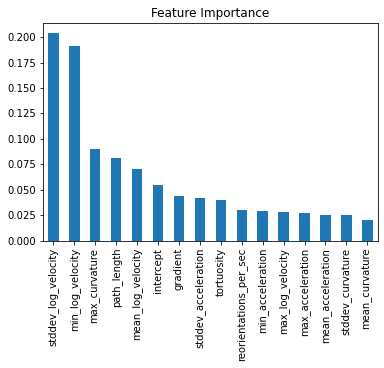

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Create an imputer for numeric columns
imputer = SimpleImputer(strategy='mean')  # Change to 'median' or 'most_frequent' as needed
X = df.drop(columns=['track_type', 'filename'])
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)
y = df['track_type']

rf = RandomForestClassifier()
rf.fit(X, y)

# Extract feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print or plot feature importance
print(importances)
importances.plot(kind='bar', title='Feature Importance')

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Separate features and target
imputer = SimpleImputer(strategy='mean')  # Change to 'median' or 'most_frequent' as needed
X = df.drop(columns=['track_type','path_length', 'filename'])
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)
y = df['track_type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Select features based on importance
selector = SelectFromModel(rf, threshold='mean', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Display selected features
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: Index(['intercept', 'mean_log_velocity', 'stddev_log_velocity',
       'min_log_velocity', 'max_curvature'],
      dtype='object')


/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [37]:
# Train MLPClassifier with selected features
mlp = MLPClassifier(max_iter=1000, random_state=42)
mlp.fit(X_train_selected, y_train)

# Predict and evaluate
y_pred = mlp.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

print("MLP Accuracy with Selected Features:", accuracy)


MLP Accuracy with Selected Features: 0.83


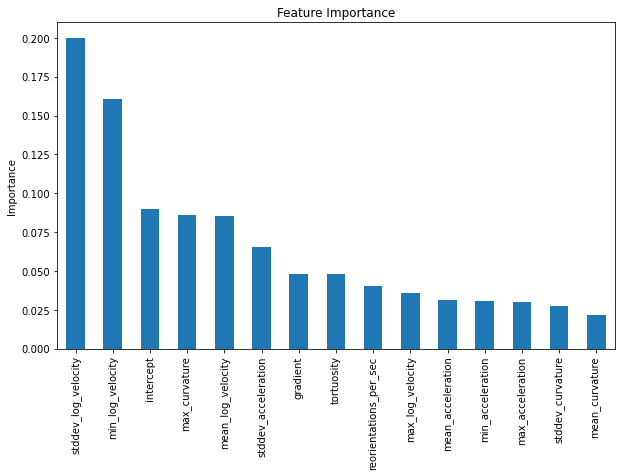

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
importances.plot(kind='bar', title='Feature Importance', figsize=(10, 6))
plt.ylabel('Importance')
plt.show()
